# Radiology Analysis with HoneyBee
The HoneyBee is a comprehensive toolkit for

## Table of Contents


In [1]:
import pydicom
import numpy as np
import cv2
import os
import json
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import torch
from torchvision import models
import pandas as pd


class DICOMPreprocessor:
    def __init__(
        self,
        target_size=None,
        window_center=None,
        window_width=None,
        normalize=True,
        to_three_channels=False,
    ):
        self.target_size = target_size
        self.window_center = window_center
        self.window_width = window_width
        self.normalize = normalize
        self.to_three_channels = to_three_channels

    def load_dicom(self, dicom_path):
        dicom_data = pydicom.dcmread(dicom_path)
        return dicom_data.pixel_array.astype(np.float32)

    def apply_windowing(self, image):
        if self.window_center is not None and self.window_width is not None:
            min_value = self.window_center - self.window_width // 2
            max_value = self.window_center + self.window_width // 2
            image = np.clip(image, min_value, max_value)
            image = (image - min_value) / (max_value - min_value)
        return image

    def resize_image(self, image):
        if self.target_size is not None:
            return cv2.resize(
                image,
                (self.target_size, self.target_size),
                interpolation=cv2.INTER_LINEAR,
            )
        return image

    def pad_or_crop(self, image):
        if self.target_size is not None:
            current_size = image.shape[0]  # Assuming square images
            if current_size < self.target_size:
                pad_amount = (self.target_size - current_size) // 2
                image = np.pad(
                    image,
                    ((pad_amount, pad_amount), (pad_amount, pad_amount)),
                    mode="constant",
                )
            elif current_size > self.target_size:
                start = (current_size - self.target_size) // 2
                image = image[
                    start : start + self.target_size, start : start + self.target_size
                ]
        return image

    def normalize_image(self, image):
        if self.normalize:
            min_val = np.min(image)
            max_val = np.max(image)
            return (
                (image - min_val) / (max_val - min_val) if max_val > min_val else image
            )
        return image

    def convert_to_three_channels(self, image):
        if self.to_three_channels and image.ndim < 3:
            return np.stack((image,) * 3, axis=-1)
        return image

    def preprocess(self, dicom_path):
        image = self.load_dicom(dicom_path)
        image = self.apply_windowing(image)
        image = self.normalize_image(image)
        image = self.resize_image(image)
        image = self.pad_or_crop(image)
        image = self.convert_to_three_channels(image)
        return image


class RadImageNet:
    def __init__(self, model_path: str) -> None:
        self.model_path = model_path
        self.model = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self._load_model()

    def _load_model(self) -> None:
        if "DenseNet121" in self.model_path:
            self.model = models.densenet121(weights=None)
        elif "InceptionV3" in self.model_path:
            self.model = models.inception_v3(weights=None)
        elif "ResNet50" in self.model_path:
            self.model = models.resnet50(weights=None)
        else:
            raise ValueError(
                "Model not recognized. Ensure the model path contains one of 'DenseNet121', 'InceptionV3', or 'ResNet50'."
            )

        state_dict = torch.load(self.model_path, map_location=self.device)
        self.model.load_state_dict(state_dict, strict=False)
        self.model.to(self.device)  # Move model to the appropriate device (GPU or CPU)
        self.model.eval()  # Set to evaluation mode

    def load_model_and_predict(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # Check input dimensions
        if self.model is None:
            raise ValueError("Model is not loaded.")
        if len(input_tensor.shape) != 4:
            raise ValueError(
                "Input tensor must be of shape [slices, 3, 224 or 299, 224 or 299]."
            )

        # Handle input size for InceptionV3
        if isinstance(self.model, models.Inception3):
            if input_tensor.shape[2:] != (299, 299):
                raise ValueError(
                    "InceptionV3 model requires input size of [slices, 3, 299, 299]."
                )
        else:
            if input_tensor.shape[2:] != (224, 224):
                raise ValueError(
                    "DenseNet121 and ResNet50 models require input size of [slices, 3, 224, 224]."
                )

        # Move input tensor to the same device as the model
        input_tensor = input_tensor.to(self.device)

        # Forward pass to generate embeddings
        with torch.no_grad():
            feature_emb = self.model(input_tensor)

        return feature_emb


radimagenet = RadImageNet("/mnt/d/Models/radimage/DenseNet121.pt")

/tmp/ipykernel_48305/461160108.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.model_path, map_location=self.device)


In [2]:
# Separate function for multiprocessing
def process_dicom_file(dicom_path, preprocessor_args):
    preprocessor = DICOMPreprocessor(**preprocessor_args)
    return preprocessor.preprocess(dicom_path)


def get_dicom_folder(folder_path):
    dicom_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".dcm"):
                file_path = os.path.join(root, file)
                dicom_paths.append(file_path)
    return dicom_paths


def process_patient(patient, preprocessor_args):
    patient_data = []
    for modality in RADIOLOGY_MODALITIES:
        if modality in patient:
            for entry in patient[modality]:
                folder_path = f"/mnt/d/TCGA/raw/TCGA-LUAD/raw/{patient.get('PatientID')}/{modality}/{entry.get('SeriesInstanceUID')}/{entry.get('SeriesInstanceUID')}"
                dicom_paths = get_dicom_folder(folder_path)

                if dicom_paths:
                    # Using ProcessPoolExecutor for multiprocessing
                    with ProcessPoolExecutor() as executor:
                        volume = list(
                            executor.map(
                                process_dicom_file,
                                dicom_paths,
                                [preprocessor_args] * len(dicom_paths),
                            )
                        )

                    # Filtering out any failed processes (returns None in case of an error)
                    volume = [v for v in volume if v is not None]

                    if volume:  # Ensure there's data before storing
                        volume_np = np.array(volume)

                        # Check if volume_np has at least 4 dimensions before transposing
                        if volume_np.ndim == 4 and volume_np.shape[3] in [
                            1,
                            3,
                        ]:  # Expecting (slices, height, width, channels)
                            slices = (
                                torch.from_numpy(volume_np.transpose(0, 3, 1, 2))
                                .float()
                                .cuda()
                            )
                            embedding = (
                                radimagenet.load_model_and_predict(slices).cpu().numpy()
                            )

                            # Serialize the arrays to byte strings
                            patient_data.append(
                                {
                                    "PatientID": patient.get("PatientID"),
                                    "Modality": modality,
                                    "SeriesInstanceUID": entry.get("SeriesInstanceUID"),
                                    "Slices": volume_np.tobytes(),  # Serialize slices
                                    "Embeddings": embedding.tobytes(),  # Serialize embeddings
                                    "EmbeddingShape": embedding.shape,  # Keep the shape for deserialization
                                }
                            )
                        else:
                            print(
                                f"Skipping {entry.get('SeriesInstanceUID')} due to incompatible volume shape: {volume_np.shape}"
                            )
    return patient_data


# Load and filter manifest
with open("/mnt/d/TCGA/raw/TCGA-LUAD/manifest.json") as f:
    manifest = json.load(f)

RADIOLOGY_MODALITIES = ["PT", "CT", "NM"]
KEYS_TO_KEEP = ["PatientID", "gdc_case_id", "PT", "CT", "NM"]

filtered_manifest = [
    {
        k: v
        for k, v in patient.items()
        if k in KEYS_TO_KEEP and any(mod in patient for mod in RADIOLOGY_MODALITIES)
    }
    for patient in manifest
]
filtered_manifest = [patient for patient in filtered_manifest if len(patient) > 1]

preprocessor_args = {
    "target_size": 224,
    "normalize": True,
    "to_three_channels": True,
}

# Limit patients
filtered_manifest = filtered_manifest[:5]

# Initialize a list to hold all the patient data
all_patient_data = []
# Process patients
for patient in tqdm(filtered_manifest, desc="Processing Patients", leave=False):
    patient_data = process_patient(patient, preprocessor_args)
    all_patient_data.extend(patient_data)

# Convert the data into a Pandas DataFrame
patient_df = pd.DataFrame(all_patient_data)

# Save DataFrame to Parquet file
output_file = "/mnt/f/Projects/HoneyBee/Radiology (RadImageNet).parquet"
patient_df.to_parquet(output_file, engine="pyarrow")

print(f"Data saved to {output_file}")

Processing Patients:   0%|          | 0/5 [00:00<?, ?it/s]

Data saved to /mnt/f/Projects/HoneyBee/Radiology (RadImageNet).parquet


PatientID                                                 TCGA-17-Z038
Modality                                                            CT
SeriesInstanceUID    1.3.6.1.4.1.14519.5.2.1.7777.9002.193487924462...
Slices               b'\xb1\xcc\x96>\xb1\xcc\x96>\xb1\xcc\x96><\xf3...
Embeddings           b'\xe8@\xf7\xbb\x80\x89#?\xf4@\x90\xbe\xea\x0b...
EmbeddingShape                                               [1, 1000]
Name: 0, dtype: object
Modality: CT, SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7777.9002.193487924462588960549189071833, Slices: (1, 224, 224)


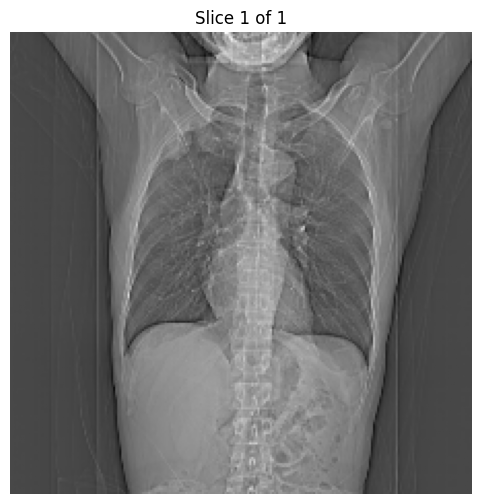

PatientID                                                 TCGA-17-Z038
Modality                                                            CT
SeriesInstanceUID    1.3.6.1.4.1.14519.5.2.1.7777.9002.144528617248...
Slices               b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
Embeddings           b'\xe8\xcb)\xbb,\x81\xbc>\xa0\x1f\x02\xbe\x82$...
EmbeddingShape                                              [23, 1000]
Name: 1, dtype: object
Modality: CT, SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7777.9002.144528617248654843333500404696, Slices: (23, 224, 224)


interactive(children=(IntSlider(value=11, description='slice_idx', max=22), Output()), _dom_classes=('widget-i…

PatientID                                                 TCGA-17-Z038
Modality                                                            CT
SeriesInstanceUID    1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822...
Slices               b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00...
Embeddings           b'\xa8 \xa5\xbc\xd9E\xdd>z\x02/\xbe\xc2\xbfh\x...
EmbeddingShape                                              [24, 1000]
Name: 2, dtype: object
Modality: CT, SeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240, Slices: (24, 224, 224)


interactive(children=(IntSlider(value=11, description='slice_idx', max=23), Output()), _dom_classes=('widget-i…

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

# Load the parquet file and filter for the desired patient
output_file = "/mnt/f/Projects/HoneyBee/Radiology (RadImageNet).parquet"
df = pd.read_parquet(output_file, engine="pyarrow")

# Patient details
patient_id = "TCGA-17-Z038"
patient_data = df[df["PatientID"] == patient_id]
# patient_data = patient_data.iloc[1:2]

# Iterate through selected slices
for i, row in patient_data.iterrows():
    slices = np.frombuffer(row["Slices"], dtype=np.float32)
    slices = slices.reshape(row["EmbeddingShape"][0], 224, 224, 3)
    slices = slices[:, :, :, 0]  # Use only one channel for grayscale visualization

    print(f"Modality: {row['Modality']}, SeriesInstanceUID: {row['SeriesInstanceUID']}, Slices: {slices.shape}")

    def show_slice(slice_idx):
        """
        Function to display a specific slice based on the slider's value.
        """
        plt.figure(figsize=(6, 6))
        plt.imshow(slices[slice_idx], cmap="gray")
        plt.title(f"Slice {slice_idx + 1} of {slices.shape[0]}")
        plt.axis("off")
        plt.show()

    # Create an interactive slider to select slices
    if slices.shape[0] > 1:
        interact(show_slice, slice_idx=(0, slices.shape[0] - 1))
    else:
        # For a single slice, directly display it
        show_slice(0)


## Generate figures for

- Background Removal using a mask
- Denoising
- Resampling
- Intensity Normalization


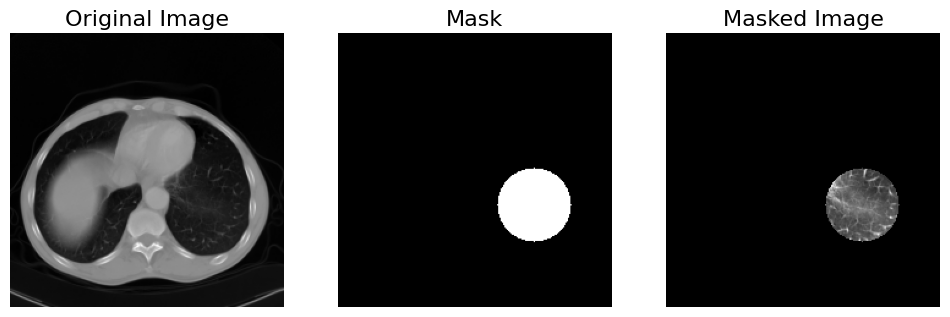

In [41]:
import cv2
import numpy as np

def remove_background(image, mask):
    """
    Function to remove the background of an image using a mask.
    """
    # Convert the mask to a binary mask
    mask = mask.astype(np.uint8)
    mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]

    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    return masked_image

# load a random slice
slice_idx = 10
image = slices[slice_idx]

# Create a mask of a circle in the lung region 
mask = np.zeros_like(image)
# a circle in the center right of the image
cv2.circle(mask, (160, 140), 30, 1, -1)

# Apply the mask to the image
masked_image = remove_background(image, mask)

# Display the original image and the masked image
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(masked_image, cmap="gray")
plt.title("Masked Image", fontsize=16)
plt.axis("off")

plt.show()


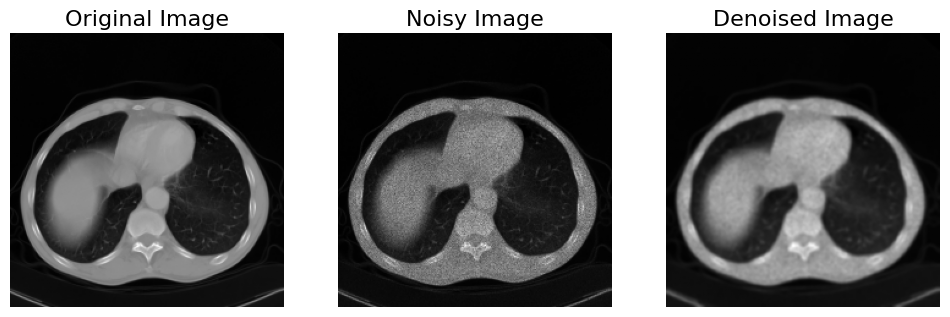

In [43]:
# Medical images often contain noise, which is mitigated using spatial or frequency
# domain filters. Speckle noise in ultrasound images is reduced using functions like
# ‘specklefilt‘. Additionally, denoising neural networks can be trained and applied for
# further enhancement.

# Load the image
image = slices[slice_idx]

# Apply speckle noise to the image
speckle_noise = np.random.normal(0, 0.1, image.shape)
noisy_image = image + image * speckle_noise

# denoise the image
def denoise_image(image):
    """
    Function to denoise an image using a Gaussian filter.
    """
    denoised_image = cv2.GaussianBlur(image, (5, 5), 0)
    return denoised_image

# Denoise the noisy image
denoised_image = denoise_image(noisy_image)

# Display the original, noisy, and denoised images
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap="gray")
plt.title("Noisy Image", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(denoised_image, cmap="gray")
plt.title("Denoised Image", fontsize=16)
plt.axis("off")

plt.show()


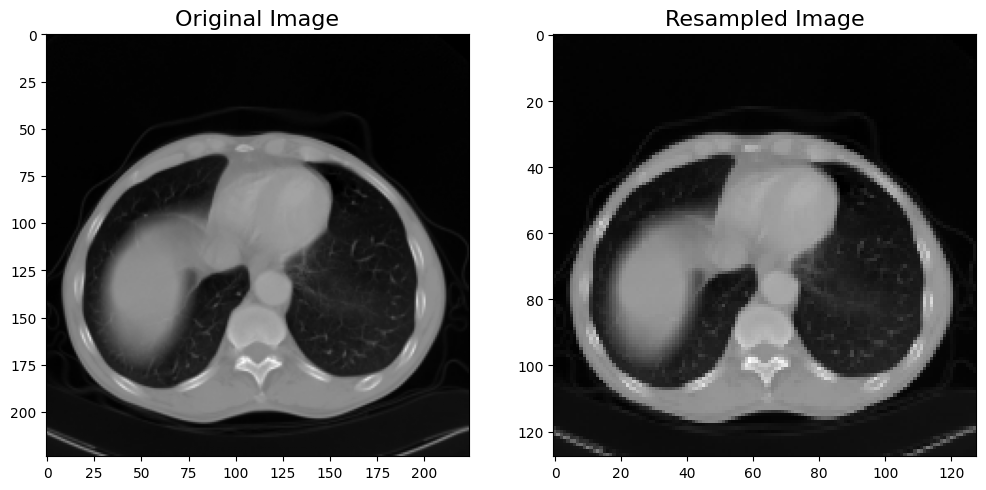

In [42]:
# resample the image to a given size

def resample_image(image, target_size):
    """
    Function to resample an image to a target size using linear interpolation.
    """
    h, w = image.shape[:2]
    new_h, new_w = target_size

    # Calculate the scale factor
    scale_h = new_h / h
    scale_w = new_w / w

    # Perform the resizing
    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    return resized_image

# Resample the image to a target size
target_size = (128, 128)
resampled_image = resample_image(image, target_size)

# Display the original and resampled images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.title("Original Image", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(resampled_image, cmap="gray")
plt.title("Resampled Image", fontsize=16)

plt.show()


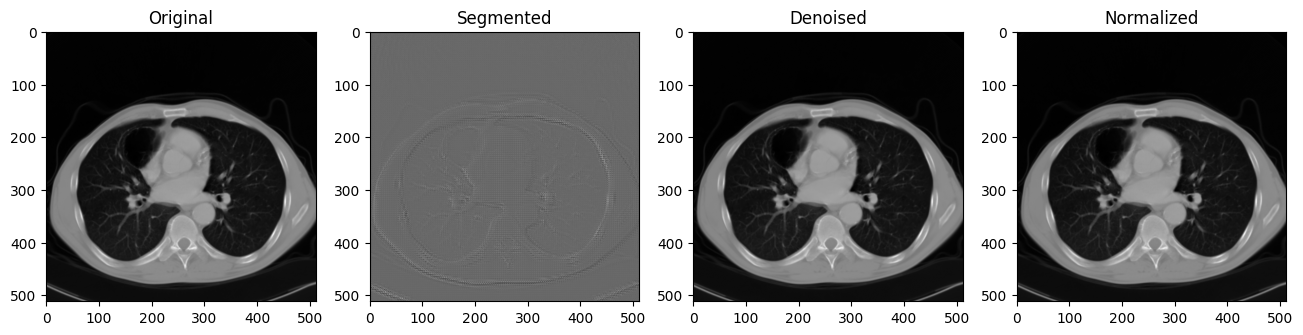

In [22]:
import os
import pydicom
import numpy as np
import torch
import cv2
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import Resize, EnsureChannelFirst
from monai.networks.nets import UNet
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_nl_means, estimate_sigma

# Load DICOM or NIfTI File
def load_medical_image(file_path):
    if file_path.endswith(".nii") or file_path.endswith(".nii.gz"):
        image = nib.load(file_path).get_fdata()
        metadata = nib.load(file_path).header
    else:
        dicom_data = pydicom.dcmread(file_path)
        image = dicom_data.pixel_array.astype(np.float32)
        metadata = dicom_data
    return metadata, image / np.max(image)  # Normalize to [0,1]

# Anatomical Segmentation
def segment_image(image):
    model = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(16, 32, 64), strides=(2, 2))
    model.eval()
    
    image = np.expand_dims(image, axis=0)  # Shape: (1, H, W)
    transform = torch.tensor(image).unsqueeze(0).float()  # Shape: (1, 1, H, W)
    
    with torch.no_grad():
        segmented = model(transform)
    return segmented.squeeze().numpy()

# Denoising Strategies
def denoise_image(image, method="gaussian", sigma=1):
    if method == "gaussian":
        return gaussian_filter(image, sigma=sigma)
    elif method == "nl_means":
        sigma_est = np.mean(estimate_sigma(image))  # Removed deprecated 'multichannel' argument
        return denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=True, patch_size=5, patch_distance=3)
    else:
        raise ValueError("Unsupported denoising method")

# Resampling for Standardized Voxel Size
def resample_image(image, new_spacing=[1.0, 1.0]):
    sitk_image = sitk.GetImageFromArray(image)
    original_spacing = [1.0, 1.0]
    new_size = [int(round(osz * osp / nsp)) for osz, osp, nsp in zip(sitk_image.GetSize(), original_spacing, new_spacing)]
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampled_image = resampler.Execute(sitk_image)
    return sitk.GetArrayFromImage(resampled_image)

# Intensity Normalization
def normalize_intensity(image, modality="CT"):
    if modality == "CT":
        return np.clip(image, -1000, 1000) / 2000 + 0.5  # Normalize to [0,1]
    elif modality == "MRI":
        return (image - np.mean(image)) / np.std(image)
    elif modality == "PET":
        return (image - np.min(image)) / (np.max(image) - np.min(image))
    else:
        return image

# Test the pipeline with a sample medical image
def test_pipeline(file_path, modality="CT"):
    metadata, image = load_medical_image(file_path)
    segmented = segment_image(image)
    denoised = denoise_image(image, method="nl_means")
    resampled = resample_image(image)
    normalized = normalize_intensity(image, modality)
    
    # Display results
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].imshow(image, cmap='gray'); axes[0].set_title('Original')
    axes[1].imshow(segmented, cmap='gray'); axes[1].set_title('Segmented')
    axes[2].imshow(denoised, cmap='gray'); axes[2].set_title('Denoised')
    axes[3].imshow(normalized, cmap='gray'); axes[3].set_title('Normalized')
    plt.show()
    
# Run the pipeline
test_pipeline('/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z038/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1-02.dcm', modality="CT")

2025-03-06 00:05:26,914 - RadiologyPipeline - INFO - Initializing RadiologyPipeline, using device: cuda
2025-03-06 00:05:26,914 - RadiologyPipeline - INFO - Step 1: Loading data
2025-03-06 00:05:26,926 - RadiologyPipeline - INFO - Loading single file: /mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z038/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1-05.dcm
2025-03-06 00:05:26,941 - RadiologyPipeline - INFO - Applied HU conversion: slope=001.000000E+00, intercept=-01.024000E+03
2025-03-06 00:05:26,942 - RadiologyPipeline - INFO - Loaded CT image with shape (512, 512)
2025-03-06 00:05:26,942 - RadiologyPipeline - INFO - Step 2: Applying denoising
2025-03-06 00:05:26,942 - RadiologyPipeline - INFO - Applying nl_means denoising
2025-03-06 00:05:27,061 - RadiologyPipeline - INFO - Applied NL Means denoising with h=0.8, patch_size=5
2025-03-06 00:05:27,062 - RadiologyPipeline - INFO - Step 3: Resampling to standard

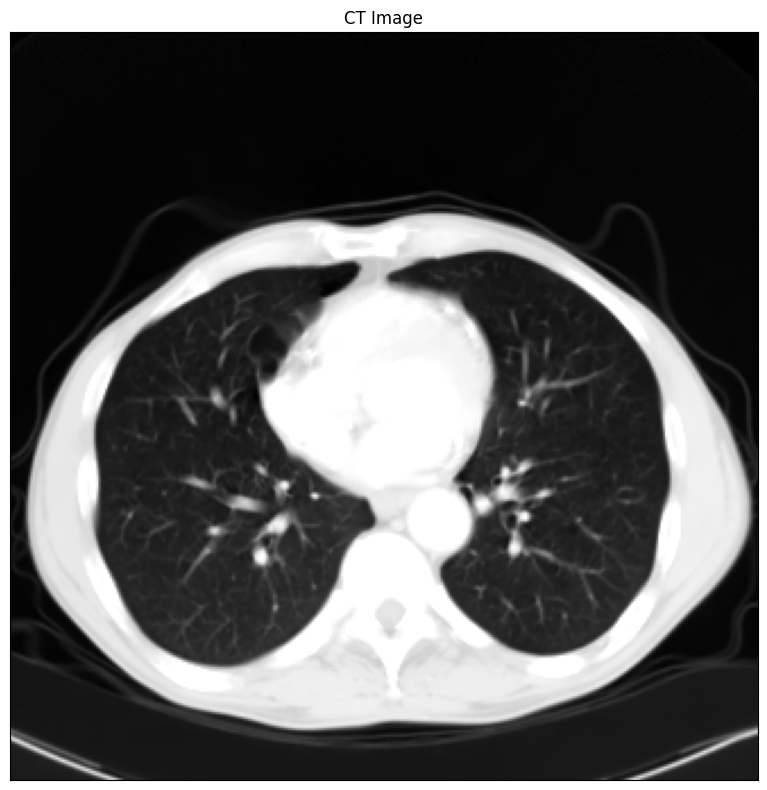

In [28]:
import os
import pydicom
import numpy as np
import torch
import cv2
import SimpleITK as sitk
import nibabel as nib
import matplotlib.pyplot as plt
from monai.transforms import Resize, EnsureChannelFirst
from monai.networks.nets import UNet
from scipy.ndimage import gaussian_filter
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.transform import resize
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.feature import canny
from scipy.ndimage import binary_fill_holes
import warnings
import logging
from concurrent.futures import ThreadPoolExecutor
import threading

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("RadiologyPipeline")

class RadiologyPipeline:
    """
    Comprehensive radiology imaging processing pipeline with support for
    DICOM and NIfTI formats, segmentation, denoising, resampling, and normalization.
    """
    
    def __init__(self, use_gpu=False):
        """
        Initialize the pipeline.
        
        Args:
            use_gpu (bool): Whether to use GPU acceleration if available
        """
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        self.metadata = None
        self.original_image = None
        self.processed_image = None
        self.segmentation_mask = None
        self.modality = None
        self.is_series = False
        self.series_data = []
        self.temporal_data = []
        self.spatial_metadata = {}
        
        logger.info(f"Initializing RadiologyPipeline, using device: {self.device}")
        
        # Initialize models (lazy loading will be implemented in actual methods)
        self.segmentation_models = {
            "CT": None,
            "MRI": None,
            "PET": None
        }
        
    def load_data(self, path, modality=None, lazy_load=True):
        """
        Load medical imaging data from DICOM or NIfTI.
        
        Args:
            path (str): Path to image file or directory containing DICOM series
            modality (str, optional): Force specific modality type (CT, MRI, PET)
            lazy_load (bool): Whether to use lazy loading for large datasets
            
        Returns:
            numpy.ndarray: Loaded image data
        """
        self.original_image = None
        self.processed_image = None
        self.metadata = None
        
        # Determine if path is file or directory
        if os.path.isdir(path):
            return self._load_dicom_series(path, lazy_load)
        elif os.path.isfile(path):
            return self._load_single_file(path, modality)
        else:
            raise ValueError(f"Invalid path: {path}")
    
    def _load_single_file(self, file_path, modality=None):
        """Load a single DICOM or NIfTI file."""
        logger.info(f"Loading single file: {file_path}")
        
        if file_path.endswith((".nii", ".nii.gz")):
            # Load NIfTI
            nifti_img = nib.load(file_path)
            self.metadata = nifti_img.header
            self.original_image = nifti_img.get_fdata()
            self.spatial_metadata = {
                "affine": nifti_img.affine,
                "pixdim": self.metadata.get_zooms(),
                "dimensions": self.original_image.shape
            }
            # Auto-detect modality from NIfTI if not specified
            if modality is None:
                # Try to infer from header or filename
                if "MR" in file_path or any(tag in str(self.metadata) for tag in ["TR", "TE", "FlipAngle"]):
                    self.modality = "MRI"
                elif "CT" in file_path or any(tag in str(self.metadata) for tag in ["kVp"]):
                    self.modality = "CT"
                elif "PET" in file_path or any(tag in str(self.metadata) for tag in ["SUV"]):
                    self.modality = "PET"
                else:
                    self.modality = "UNKNOWN"
                    logger.warning("Could not determine modality from NIfTI file, defaulting to UNKNOWN")
            else:
                self.modality = modality
                
        else:
            # Assume DICOM
            try:
                dicom_data = pydicom.dcmread(file_path)
                self.metadata = dicom_data
                self.original_image = dicom_data.pixel_array.astype(np.float32)
                
                # Extract spatial metadata
                self.spatial_metadata = {
                    "pixel_spacing": getattr(dicom_data, "PixelSpacing", [1.0, 1.0]),
                    "slice_thickness": getattr(dicom_data, "SliceThickness", 1.0),
                    "dimensions": self.original_image.shape
                }
                
                # Auto-detect modality from DICOM if not specified
                if modality is None:
                    try:
                        self.modality = dicom_data.Modality
                    except AttributeError:
                        self.modality = "UNKNOWN"
                        logger.warning("Could not determine modality from DICOM file, defaulting to UNKNOWN")
                else:
                    self.modality = modality
                    
                # Handle specific modality preprocessing
                if self.modality == "CT":
                    self._preprocess_ct(dicom_data)
                elif self.modality == "MRI":
                    self._preprocess_mri(dicom_data)
                elif self.modality == "PET":
                    self._preprocess_pet(dicom_data)
                    
            except Exception as e:
                logger.error(f"Error loading DICOM file: {e}")
                raise
        
        self.processed_image = self.original_image.copy()
        logger.info(f"Loaded {self.modality} image with shape {self.original_image.shape}")
        return self.original_image
    
    def _load_dicom_series(self, directory_path, lazy_load=True):
        """Load a series of DICOM files from directory."""
        logger.info(f"Loading DICOM series from directory: {directory_path}")
        
        # Get all DICOM files in directory
        dicom_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                      if f.endswith(('.dcm', '.DCM')) or os.path.isdir(os.path.join(directory_path, f))]
        
        if not dicom_files:
            raise ValueError(f"No DICOM files found in {directory_path}")
        
        # Read first file to determine metadata and modality
        first_dicom = pydicom.dcmread(dicom_files[0])
        self.metadata = first_dicom  # Use first file's metadata as reference
        
        try:
            self.modality = first_dicom.Modality
        except AttributeError:
            self.modality = "UNKNOWN"
            logger.warning("Could not determine modality from DICOM series, defaulting to UNKNOWN")
            
        # Sort files by instance number or acquisition time
        sorted_files = []
        for file_path in dicom_files:
            try:
                dcm = pydicom.dcmread(file_path, stop_before_pixels=True)
                try:
                    instance_num = int(dcm.InstanceNumber)
                except (AttributeError, ValueError):
                    # If no instance number, try acquisition time
                    try:
                        instance_num = dcm.AcquisitionTime
                    except AttributeError:
                        # Last resort: use filename
                        instance_num = os.path.basename(file_path)
                sorted_files.append((instance_num, file_path))
            except Exception as e:
                logger.warning(f"Skipping file {file_path}: {e}")
                
        sorted_files.sort(key=lambda x: x[0])
        dicom_files = [file_path for _, file_path in sorted_files]
        
        # Determine if this is a temporal series (4D)
        is_temporal = False
        if len(dicom_files) > 1:
            try:
                # Check if we have acquisition times that differ
                first_acq_time = getattr(pydicom.dcmread(dicom_files[0], stop_before_pixels=True), 'AcquisitionTime', None)
                last_acq_time = getattr(pydicom.dcmread(dicom_files[-1], stop_before_pixels=True), 'AcquisitionTime', None)
                if first_acq_time and last_acq_time and first_acq_time != last_acq_time:
                    is_temporal = True
                    logger.info("Detected temporal series (4D data)")
            except Exception:
                pass
        
        # Loading strategy based on lazy_load flag
        if lazy_load:
            # Just store paths and load on demand
            self.is_series = True
            self.series_data = dicom_files
            
            # Load first slice for immediate use
            first_slice = pydicom.dcmread(dicom_files[0]).pixel_array.astype(np.float32)
            self.original_image = first_slice
            self.processed_image = first_slice.copy()
            
            # Extract spatial metadata from first slice
            first_dicom = pydicom.dcmread(dicom_files[0])
            self.spatial_metadata = {
                "pixel_spacing": getattr(first_dicom, "PixelSpacing", [1.0, 1.0]),
                "slice_thickness": getattr(first_dicom, "SliceThickness", 1.0),
                "dimensions": (len(dicom_files), *first_slice.shape),
                "is_temporal": is_temporal
            }
            
            logger.info(f"Lazy-loaded DICOM series with {len(dicom_files)} files")
            return first_slice
            
        else:
            # Load all slices into memory
            with ThreadPoolExecutor(max_workers=8) as executor:
                slices = list(executor.map(lambda f: pydicom.dcmread(f).pixel_array.astype(np.float32), dicom_files))
            
            # Stack slices into 3D volume
            self.original_image = np.stack(slices, axis=0)
            self.processed_image = self.original_image.copy()
            
            # Extract spatial metadata
            self.spatial_metadata = {
                "pixel_spacing": getattr(first_dicom, "PixelSpacing", [1.0, 1.0]),
                "slice_thickness": getattr(first_dicom, "SliceThickness", 1.0),
                "dimensions": self.original_image.shape,
                "is_temporal": is_temporal
            }
            
            logger.info(f"Loaded full DICOM series with shape {self.original_image.shape}")
            return self.original_image
    
    def load_slice(self, index):
        """Load a specific slice from a DICOM series."""
        if not self.is_series or not self.series_data:
            raise ValueError("No series data available")
            
        if index < 0 or index >= len(self.series_data):
            raise IndexError(f"Slice index {index} out of range (0-{len(self.series_data)-1})")
            
        slice_data = pydicom.dcmread(self.series_data[index]).pixel_array.astype(np.float32)
        return slice_data
    
    def _preprocess_ct(self, dicom_data):
        """Specialized preprocessing for CT images."""
        # Apply Hounsfield unit conversion if needed
        try:
            intercept = dicom_data.RescaleIntercept
            slope = dicom_data.RescaleSlope
            self.original_image = self.original_image * slope + intercept
            logger.info(f"Applied HU conversion: slope={slope}, intercept={intercept}")
        except AttributeError:
            logger.warning("Could not convert to Hounsfield units, missing slope/intercept")
    
    def _preprocess_mri(self, dicom_data):
        """Specialized preprocessing for MRI images."""
        # Store sequence parameters
        self.mri_metadata = {
            "field_strength": getattr(dicom_data, "MagneticFieldStrength", None),
            "tr": getattr(dicom_data, "RepetitionTime", None),
            "te": getattr(dicom_data, "EchoTime", None),
            "sequence_name": getattr(dicom_data, "SequenceName", None),
            "flip_angle": getattr(dicom_data, "FlipAngle", None)
        }
    
    def _preprocess_pet(self, dicom_data):
        """Specialized preprocessing for PET images."""
        # Store radiopharmaceutical info and SUV factors
        try:
            # Extract radiopharmaceutical info
            if hasattr(dicom_data, 'RadiopharmaceuticalInformationSequence'):
                radiopharm_seq = dicom_data.RadiopharmaceuticalInformationSequence[0]
                self.pet_metadata = {
                    "radiopharmaceutical": getattr(radiopharm_seq, "Radiopharmaceutical", None),
                    "half_life": getattr(radiopharm_seq, "RadionuclideHalfLife", None),
                    "injection_time": getattr(radiopharm_seq, "RadiopharmaceuticalStartTime", None),
                    "start_datetime": getattr(dicom_data, "SeriesDate", "") + getattr(dicom_data, "SeriesTime", ""),
                    "decay_correction": getattr(dicom_data, "DecayCorrection", None),
                    "patient_weight": getattr(dicom_data, "PatientWeight", None)
                }
        except (AttributeError, IndexError):
            self.pet_metadata = {}
            logger.warning("Could not extract complete PET metadata")
    
    def segment(self, method="auto", organ=None, params=None):
        """
        Perform image segmentation using different methods.
        
        Args:
            method (str): Segmentation method - "auto", "thresholding", "edge", "deep_learning"
            organ (str, optional): Target organ for specialized segmentation (lung, brain, liver, etc.)
            params (dict, optional): Additional parameters for the segmentation method
            
        Returns:
            numpy.ndarray: Binary segmentation mask
        """
        if self.original_image is None:
            raise ValueError("No image data loaded")
            
        logger.info(f"Performing segmentation with method={method}, organ={organ}")
        params = params or {}
        
        # Choose appropriate segmentation method based on modality and organ
        if method == "auto":
            if self.modality == "CT":
                if organ == "lung":
                    return self._segment_ct_lungs()
                elif organ == "bone":
                    return self._segment_ct_bone()
                else:
                    return self._segment_by_thresholding()
            elif self.modality == "MRI":
                if organ == "brain":
                    return self._segment_mri_brain()
                else:
                    return self._segment_by_edge_detection()
            elif self.modality == "PET":
                return self._segment_pet_hypermetabolic()
            else:
                return self._segment_by_thresholding()
        elif method == "thresholding":
            return self._segment_by_thresholding(**params)
        elif method == "edge":
            return self._segment_by_edge_detection(**params)
        elif method == "deep_learning":
            return self._segment_by_deep_learning(organ=organ, **params)
        else:
            raise ValueError(f"Unsupported segmentation method: {method}")
    
    def _segment_by_thresholding(self, threshold=None, closing_size=3):
        """Simple thresholding-based segmentation."""
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Make a 2D slice if volume
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Normalize image for thresholding
        normalized = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
        
        # Compute optimal threshold if none provided
        if threshold is None:
            try:
                threshold = threshold_otsu(normalized)
            except:
                threshold = 0.5
                logger.warning("Could not compute Otsu threshold, using default 0.5")
                
        # Apply threshold
        binary = normalized > threshold
        
        # Post-process: closing to remove small holes
        binary = closing(binary, square(closing_size))
        
        # Fill holes in the binary mask
        binary = binary_fill_holes(binary)
        
        self.segmentation_mask = binary
        logger.info(f"Thresholding segmentation complete, threshold={threshold}")
        return binary
    
    def _segment_by_edge_detection(self, sigma=1.0):
        """Edge-based segmentation using Canny edge detector."""
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Handle 3D data
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Normalize image for edge detection
        normalized = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
        
        # Apply Canny edge detection
        edges = canny(normalized, sigma=sigma)
        
        # Fill holes
        filled = binary_fill_holes(edges)
        
        self.segmentation_mask = filled
        logger.info("Edge-based segmentation complete")
        return filled
    
    def _segment_by_deep_learning(self, organ=None, model_path=None):
        """Deep learning-based segmentation using UNet."""
        # This is a placeholder - in a real implementation we'd load specific models
        # for different organs/modalities
        
        # Initialize UNet model if needed
        if self.use_gpu:
            model = UNet(
                spatial_dims=2, 
                in_channels=1, 
                out_channels=1, 
                channels=(16, 32, 64, 128), 
                strides=(2, 2, 2)
            ).to(self.device)
        else:
            model = UNet(
                spatial_dims=2, 
                in_channels=1, 
                out_channels=1, 
                channels=(16, 32, 64), 
                strides=(2, 2)
            )
        
        # In a real implementation, we would load pretrained weights
        if model_path:
            try:
                model.load_state_dict(torch.load(model_path, map_location=self.device))
                logger.info(f"Loaded model weights from {model_path}")
            except Exception as e:
                logger.error(f"Failed to load model weights: {e}")
                # Continue with uninitialized model for demo purposes
                
        model.eval()
        
        # Handle 3D data
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Prepare input for the model
        # Normalize to [0, 1]
        normalized = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
        
        # Resize to model's expected input size
        resized = resize(normalized, (256, 256), anti_aliasing=True)
        
        # Add batch and channel dimensions
        input_tensor = torch.tensor(resized).float().unsqueeze(0).unsqueeze(0).to(self.device)
        
        # Run inference
        with torch.no_grad():
            output = model(input_tensor)
            
        # Post-process output
        segmentation = output.squeeze().cpu().numpy() > 0.5
        
        # Resize back to original dimensions
        resized_segmentation = resize(segmentation.astype(float), 
                                      image_2d.shape, 
                                      order=0, 
                                      anti_aliasing=False,
                                      preserve_range=True).astype(bool)
        
        self.segmentation_mask = resized_segmentation
        logger.info(f"Deep learning segmentation complete for {organ or 'general'} segmentation")
        return resized_segmentation
    
    def _segment_ct_lungs(self):
        """Specialized function for lung segmentation in CT images."""
        if self.modality != "CT":
            logger.warning("Lung segmentation optimized for CT, but current modality is " + self.modality)
            
        # Handle 3D data
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Threshold for air (-1000 to -600 HU is typically lungs)
        thresholded = (image_2d > -1000) & (image_2d < -600)
        
        # Clean up with morphological operations
        cleaned = closing(thresholded, square(5))
        
        # Remove small objects and fill holes
        labeled = label(cleaned)
        regions = regionprops(labeled)
        
        # Keep only the largest regions (lungs)
        for prop in regions:
            if prop.area < 1000:  # Size threshold
                cleaned[labeled == prop.label] = 0
                
        filled = binary_fill_holes(cleaned)
        
        self.segmentation_mask = filled
        logger.info("CT lung segmentation complete")
        return filled
    
    def _segment_ct_bone(self):
        """Specialized function for bone segmentation in CT images."""
        if self.modality != "CT":
            logger.warning("Bone segmentation optimized for CT, but current modality is " + self.modality)
            
        # Handle 3D data
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Threshold for bone (typically >200 HU)
        bone_mask = image_2d > 200
        
        # Clean up with morphological operations
        cleaned = closing(bone_mask, square(3))
        
        self.segmentation_mask = cleaned
        logger.info("CT bone segmentation complete")
        return cleaned
    
    def _segment_mri_brain(self):
        """Specialized function for brain segmentation in MRI images."""
        if self.modality != "MRI":
            logger.warning("Brain segmentation optimized for MRI, but current modality is " + self.modality)
            
        # In a real implementation, this would be a more sophisticated algorithm
        # For now, demonstrate with basic thresholding
        
        # Handle 3D data
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Normalize image
        normalized = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
        
        # Apply Otsu thresholding
        try:
            thresh = threshold_otsu(normalized)
        except:
            thresh = 0.5
            
        brain_mask = normalized > thresh
        
        # Clean up with morphological operations
        cleaned = closing(brain_mask, square(5))
        filled = binary_fill_holes(cleaned)
        
        self.segmentation_mask = filled
        logger.info("MRI brain segmentation complete")
        return filled
    
    def _segment_pet_hypermetabolic(self):
        """Specialized function for hypermetabolic region segmentation in PET images."""
        if self.modality != "PET":
            logger.warning("Hypermetabolic segmentation optimized for PET, but current modality is " + self.modality)
            
        # Handle 3D data
        if len(self.processed_image.shape) > 2:
            # For 3D, segment middle slice
            middle_slice_idx = self.processed_image.shape[0] // 2
            image_2d = self.processed_image[middle_slice_idx]
        else:
            image_2d = self.processed_image
            
        # Normalize image
        normalized = (image_2d - np.min(image_2d)) / (np.max(image_2d) - np.min(image_2d))
        
        # Threshold for high uptake regions (e.g., SUV > 2.5)
        # In practice, this would be based on absolute SUV values
        uptake_mask = normalized > 0.6  # Arbitrary threshold for demo
        
        # Clean up with morphological operations
        cleaned = closing(uptake_mask, square(3))
        
        self.segmentation_mask = cleaned
        logger.info("PET hypermetabolic segmentation complete")
        return cleaned
    
    def denoise(self, method="auto", **kwargs):
        """
        Apply denoising to the current image.
        
        Args:
            method (str): Denoising method - "auto", "gaussian", "nl_means", "wavelet", "bilateral"
            **kwargs: Additional parameters for the specific denoising method
            
        Returns:
            numpy.ndarray: Denoised image
        """
        if self.original_image is None:
            raise ValueError("No image data loaded")
            
        # Choose appropriate method based on modality if auto
        if method == "auto":
            if self.modality == "CT":
                method = "nl_means"
            elif self.modality == "MRI":
                method = "wavelet"
            elif self.modality == "PET":
                method = "gaussian"
            else:
                method = "gaussian"
                
        logger.info(f"Applying {method} denoising")
        
        # Apply different denoising methods based on selection
        if method == "gaussian":
            sigma = kwargs.get("sigma", 1.0)
            if len(self.processed_image.shape) > 2:
                # For 3D, apply to each slice
                denoised = np.zeros_like(self.processed_image)
                for i in range(self.processed_image.shape[0]):
                    denoised[i] = gaussian_filter(self.processed_image[i], sigma=sigma)
            else:
                denoised = gaussian_filter(self.processed_image, sigma=sigma)
                
            logger.info(f"Applied Gaussian denoising with sigma={sigma}")
                
        elif method == "nl_means":
            h = kwargs.get("h", 0.8)
            patch_size = kwargs.get("patch_size", 5)
            patch_distance = kwargs.get("patch_distance", 6)
            
            if len(self.processed_image.shape) > 2:
                # For 3D, apply to each slice
                denoised = np.zeros_like(self.processed_image)
                for i in range(self.processed_image.shape[0]):
                    # Normalize slice for NL means
                    slice_min = np.min(self.processed_image[i])
                    slice_max = np.max(self.processed_image[i])
                    normalized = (self.processed_image[i] - slice_min) / (slice_max - slice_min)
                    
                    # Denoise
                    sigma_est = np.mean(estimate_sigma(normalized))
                    denoised_slice = denoise_nl_means(
                        normalized, 
                        h=h * sigma_est,
                        fast_mode=True,
                        patch_size=patch_size,
                        patch_distance=patch_distance
                    )
                    
                    # Scale back to original range
                    denoised[i] = denoised_slice * (slice_max - slice_min) + slice_min
            else:
                # Normalize for NL means
                img_min = np.min(self.processed_image)
                img_max = np.max(self.processed_image)
                normalized = (self.processed_image - img_min) / (img_max - img_min)
                
                # Denoise
                sigma_est = np.mean(estimate_sigma(normalized))
                denoised_norm = denoise_nl_means(
                    normalized, 
                    h=h * sigma_est,
                    fast_mode=True,
                    patch_size=patch_size,
                    patch_distance=patch_distance
                )
                
                # Scale back to original range
                denoised = denoised_norm * (img_max - img_min) + img_min
                
            logger.info(f"Applied NL Means denoising with h={h}, patch_size={patch_size}")
                
        elif method == "wavelet":
            # This would typically use a wavelet-based denoiser
            # For this example, we'll use a simplified version with Gaussian
            sigma = kwargs.get("sigma", 0.8)
            if len(self.processed_image.shape) > 2:
                denoised = np.zeros_like(self.processed_image)
                for i in range(self.processed_image.shape[0]):
                    denoised[i] = gaussian_filter(self.processed_image[i], sigma=sigma)
            else:
                denoised = gaussian_filter(self.processed_image, sigma=sigma)
                
            logger.info(f"Applied simplified wavelet denoising (Gaussian with sigma={sigma})")
                
        elif method == "bilateral":
            sigma_color = kwargs.get("sigma_color", 0.1)
            sigma_spatial = kwargs.get("sigma_spatial", 1.0)
            
            # Use a simplified implementation
            if len(self.processed_image.shape) > 2:
                denoised = np.zeros_like(self.processed_image)
                for i in range(self.processed_image.shape[0]):
                    # Normalize slice
                    slice_min = np.min(self.processed_image[i])
                    slice_max = np.max(self.processed_image[i])
                    normalized = (self.processed_image[i] - slice_min) / (slice_max - slice_min)
                    
                    # Apply bilateral filter
                    filtered = cv2.bilateralFilter(
                        normalized.astype(np.float32),
                        d=int(sigma_spatial * 3),
                        sigmaColor=sigma_color,
                        sigmaSpace=sigma_spatial
                    )
                    
                    # Scale back to original range
                    denoised[i] = filtered * (slice_max - slice_min) + slice_min
            else:
                # Normalize for bilateral filter
                img_min = np.min(self.processed_image)
                img_max = np.max(self.processed_image)
                normalized = (self.processed_image - img_min) / (img_max - img_min)
                
                # Apply bilateral filter
                filtered = cv2.bilateralFilter(
                    normalized.astype(np.float32),
                    d=int(sigma_spatial * 3),
                    sigmaColor=sigma_color,
                    sigmaSpace=sigma_spatial
                )
                
                # Scale back to original range
                denoised = filtered * (img_max - img_min) + img_min
                
            logger.info(f"Applied bilateral filtering with sigma_color={sigma_color}, sigma_spatial={sigma_spatial}")
                
        else:
            raise ValueError(f"Unsupported denoising method: {method}")
            
        # Store denoised image and return
        self.processed_image = denoised
        return denoised
    
    def resample(self, new_spacing=None, new_size=None, interpolation="linear"):
        """
        Resample image to new spacing or size.
        
        Args:
            new_spacing (list/tuple): New pixel/voxel spacing [x, y, z]
            new_size (list/tuple): New image dimensions [x, y, z]
            interpolation (str): Interpolation method - linear, nearest, bspline
            
        Returns:
            numpy.ndarray: Resampled image
        """
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Get current spacing from metadata if available
        if self.modality == "CT" or self.modality == "MRI" or self.modality == "PET":
            try:
                if "pixel_spacing" in self.spatial_metadata:
                    current_spacing = self.spatial_metadata["pixel_spacing"]
                    if "slice_thickness" in self.spatial_metadata and len(self.processed_image.shape) > 2:
                        current_spacing = [*current_spacing, self.spatial_metadata["slice_thickness"]]
                else:
                    # Default to isotropic if not available
                    dimensions = len(self.processed_image.shape)
                    current_spacing = [1.0] * dimensions
                    logger.warning("No spacing information found, assuming isotropic voxels")
            except Exception as e:
                logger.warning(f"Error getting current spacing: {e}, assuming isotropic")
                dimensions = len(self.processed_image.shape)
                current_spacing = [1.0] * dimensions
        else:
            dimensions = len(self.processed_image.shape)
            current_spacing = [1.0] * dimensions
            
        logger.info(f"Current spacing: {current_spacing}")
        
        # If neither new_spacing nor new_size specified, use isotropic spacing
        if new_spacing is None and new_size is None:
            # Default to isotropic with minimum current spacing
            min_spacing = min(current_spacing)
            new_spacing = [min_spacing] * len(current_spacing)
            logger.info(f"No new spacing or size specified, using isotropic spacing of {min_spacing}")
            
        # Convert the image to SimpleITK for resampling
        sitk_image = sitk.GetImageFromArray(self.processed_image)
        
        # Set the spacing
        if len(current_spacing) == len(self.processed_image.shape):
            # For 3D, SimpleITK needs spacing in reverse order
            sitk_image.SetSpacing(current_spacing[::-1])
        elif len(self.processed_image.shape) == 2 and len(current_spacing) >= 2:
            sitk_image.SetSpacing(current_spacing[:2][::-1])
        else:
            # Just use default spacing
            sitk_image.SetSpacing([1.0] * len(self.processed_image.shape))
            
        # Configure resampler
        resampler = sitk.ResampleImageFilter()
        
        if interpolation == "linear":
            resampler.SetInterpolator(sitk.sitkLinear)
        elif interpolation == "nearest":
            resampler.SetInterpolator(sitk.sitkNearestNeighbor)
        elif interpolation == "bspline":
            resampler.SetInterpolator(sitk.sitkBSpline)
        elif interpolation == "lanczos":
            resampler.SetInterpolator(sitk.sitkLanczos)
        else:
            logger.warning(f"Unknown interpolation method: {interpolation}, using linear")
            resampler.SetInterpolator(sitk.sitkLinear)
            
        # Calculate output parameters
        if new_spacing is not None:
            # Ensure new_spacing has the right dimensions
            if len(new_spacing) != len(current_spacing):
                if len(self.processed_image.shape) == 2 and len(new_spacing) > 2:
                    new_spacing = new_spacing[:2]
                elif len(self.processed_image.shape) == 3 and len(new_spacing) < 3:
                    new_spacing = list(new_spacing) + [current_spacing[-1]]
                    
            # Calculate new size based on spacing
            if len(self.processed_image.shape) == 3:  # 3D
                orig_size = self.processed_image.shape[::-1]  # SimpleITK uses [z,y,x] order
                new_size_calc = [int(round(osz * osp / nsp)) for osz, osp, nsp in 
                                zip(orig_size, sitk_image.GetSpacing(), new_spacing)]
            else:  # 2D
                orig_size = self.processed_image.shape[::-1]  # SimpleITK uses [y,x] order
                new_size_calc = [int(round(osz * osp / nsp)) for osz, osp, nsp in 
                                zip(orig_size, sitk_image.GetSpacing(), new_spacing[:2])]
                
            resampler.SetOutputSpacing(new_spacing[:len(orig_size)][::-1])  # Reverse order for SimpleITK
            resampler.SetSize(new_size_calc)
            
        elif new_size is not None:
            # Ensure new_size has the right dimensions
            if len(new_size) != len(self.processed_image.shape):
                if len(self.processed_image.shape) == 2 and len(new_size) > 2:
                    new_size = new_size[:2]
                elif len(self.processed_image.shape) == 3 and len(new_size) < 3:
                    new_size = list(new_size) + [self.processed_image.shape[0]]
                    
            # Calculate new spacing based on size
            if len(self.processed_image.shape) == 3:  # 3D
                orig_size = self.processed_image.shape[::-1]  # SimpleITK uses [z,y,x] order
                new_spacing_calc = [osp * osz / nsz for osz, osp, nsz in 
                                  zip(orig_size, sitk_image.GetSpacing(), new_size[::-1])]
            else:  # 2D
                orig_size = self.processed_image.shape[::-1]  # SimpleITK uses [y,x] order
                new_spacing_calc = [osp * osz / nsz for osz, osp, nsz in 
                                  zip(orig_size, sitk_image.GetSpacing(), new_size[::-1])]
                
            resampler.SetOutputSpacing(new_spacing_calc)
            resampler.SetSize(new_size[::-1])  # Reverse order for SimpleITK
        
        # Preserve modality-specific values
        if self.modality == "CT":
            # Default pixel value should be air (-1000) for CT
            resampler.SetDefaultPixelValue(-1000)
        else:
            resampler.SetDefaultPixelValue(0)
            
        # Set other resampling parameters
        resampler.SetOutputOrigin(sitk_image.GetOrigin())
        resampler.SetOutputDirection(sitk_image.GetDirection())
        
        # Perform resampling
        logger.info(f"Resampling with interpolation={interpolation}, " +
                   f"output_size={resampler.GetSize()}, output_spacing={resampler.GetOutputSpacing()}")
        
        try:
            resampled_sitk = resampler.Execute(sitk_image)
            resampled_array = sitk.GetArrayFromImage(resampled_sitk)
            
            # Update image and metadata
            self.processed_image = resampled_array
            
            # Update spacing metadata
            if len(self.processed_image.shape) == 3:
                self.spatial_metadata["resampled_spacing"] = list(resampled_sitk.GetSpacing()[::-1])
            else:
                self.spatial_metadata["resampled_spacing"] = list(resampled_sitk.GetSpacing()[::-1])
                
            logger.info(f"Resampling complete, new shape: {self.processed_image.shape}")
            return resampled_array
            
        except Exception as e:
            logger.error(f"Resampling failed: {e}")
            raise
    
    def normalize(self, method="auto", window=None, level=None):
        """
        Apply intensity normalization to the current image.
        
        Args:
            method (str): Normalization method - "auto", "minmax", "zscore", "window_level"
            window (float): Window width for windowing (for CT)
            level (float): Window level/center for windowing (for CT)
            
        Returns:
            numpy.ndarray: Normalized image
        """
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Choose appropriate method based on modality if auto
        if method == "auto":
            if self.modality == "CT":
                method = "window_level"
                # Default to lung window if not specified
                if window is None or level is None:
                    window, level = 1500, -600  # Lung window
            elif self.modality == "MRI":
                method = "zscore"
            elif self.modality == "PET":
                method = "suv"
            else:
                method = "minmax"
                
        logger.info(f"Applying {method} normalization")
        
        # Apply different normalization methods
        if method == "minmax":
            img_min = np.min(self.processed_image)
            img_max = np.max(self.processed_image)
            normalized = (self.processed_image - img_min) / (img_max - img_min)
            logger.info(f"Applied min-max normalization, range: [{img_min}, {img_max}] -> [0, 1]")
            
        elif method == "zscore":
            img_mean = np.mean(self.processed_image)
            img_std = np.std(self.processed_image)
            normalized = (self.processed_image - img_mean) / img_std
            logger.info(f"Applied z-score normalization, mean={img_mean:.2f}, std={img_std:.2f}")
            
        elif method == "window_level":
            # Apply CT windowing (window/level)
            if window is None:
                window = 400  # Default abdominal window width
            if level is None:
                level = 40   # Default abdominal window level
            
            # Calculate window boundaries
            window_min = level - window/2
            window_max = level + window/2
            
            # Apply windowing
            normalized = np.clip(self.processed_image, window_min, window_max)
            normalized = (normalized - window_min) / (window_max - window_min)
            logger.info(f"Applied window/level normalization: window={window}, level={level}")
            
        elif method == "suv":
            # This would require the full PET metadata
            # For this example, we'll use minmax as a simplified approach
            img_min = np.min(self.processed_image)
            img_max = np.max(self.processed_image)
            normalized = (self.processed_image - img_min) / (img_max - img_min)
            logger.info("Applied simplified SUV normalization (min-max)")
            
        else:
            raise ValueError(f"Unsupported normalization method: {method}")
            
        # Store normalized image and return
        self.processed_image = normalized
        return normalized
    
    def apply_mask(self, mask=None, fill_value=0):
        """
        Apply a binary mask to the image.
        
        Args:
            mask (numpy.ndarray, optional): Binary mask to apply. If None, uses the current segmentation mask.
            fill_value (float): Value to fill in masked regions
            
        Returns:
            numpy.ndarray: Masked image
        """
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Use current segmentation mask if none provided
        if mask is None:
            if self.segmentation_mask is None:
                raise ValueError("No segmentation mask available. Generate one first with segment() method.")
            mask = self.segmentation_mask
            
        # Ensure mask shape matches image shape
        if mask.shape != self.processed_image.shape:
            if len(self.processed_image.shape) > 2 and len(mask.shape) == 2:
                # Broadcast 2D mask to 3D if needed
                expanded_mask = np.zeros_like(self.processed_image, dtype=bool)
                middle_slice = self.processed_image.shape[0] // 2
                expanded_mask[middle_slice] = mask
                mask = expanded_mask
                logger.warning("Expanded 2D mask to 3D by placing it at the middle slice.")
            else:
                raise ValueError(f"Mask shape {mask.shape} does not match image shape {self.processed_image.shape}")
                
        # Apply mask
        masked_image = self.processed_image.copy()
        masked_image[~mask] = fill_value
        
        self.processed_image = masked_image
        logger.info(f"Applied mask with fill_value={fill_value}")
        return masked_image
    
    def extract_region_properties(self, label_image=None):
        """
        Extract properties from segmented regions.
        
        Args:
            label_image (numpy.ndarray, optional): Labeled image. If None, uses binary segmentation mask.
            
        Returns:
            dict: Dictionary of region properties
        """
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Use segmentation mask if no label image provided
        if label_image is None:
            if self.segmentation_mask is None:
                raise ValueError("No segmentation mask available. Generate one first with segment() method.")
                
            # Convert binary mask to label image
            label_image = label(self.segmentation_mask)
            
        # Extract region properties
        regions = regionprops(label_image, intensity_image=self.processed_image)
        
        if not regions:
            logger.warning("No regions found in the label image")
            return {}
            
        # Collect properties for all regions
        all_props = []
        for i, prop in enumerate(regions):
            region_props = {
                "label": prop.label,
                "area": prop.area,
                "centroid": prop.centroid,
                "bbox": prop.bbox,
                "major_axis_length": getattr(prop, "major_axis_length", None),
                "minor_axis_length": getattr(prop, "minor_axis_length", None),
                "eccentricity": getattr(prop, "eccentricity", None),
                "mean_intensity": getattr(prop, "mean_intensity", None),
                "max_intensity": getattr(prop, "max_intensity", None),
                "min_intensity": getattr(prop, "min_intensity", None)
            }
            all_props.append(region_props)
            
        logger.info(f"Extracted properties for {len(all_props)} regions")
        return all_props
    
    def save_results(self, output_dir, base_filename=None, formats=None):
        """
        Save the processed image and segmentation mask to disk.
        
        Args:
            output_dir (str): Directory to save results
            base_filename (str, optional): Base filename for saving. If None, generates a timestamp-based name.
            formats (list, optional): List of formats to save in. Default is ["nii.gz", "png"]
            
        Returns:
            dict: Dictionary of saved file paths
        """
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Generate base filename if not provided
        if base_filename is None:
            import time
            base_filename = f"processed_{int(time.time())}"
            
        # Default formats
        if formats is None:
            formats = ["nii.gz", "png"]
            
        saved_files = {}
        
        # Save in requested formats
        for fmt in formats:
            if fmt in ["nii", "nii.gz"]:
                # Save as NIfTI
                processed_path = os.path.join(output_dir, f"{base_filename}_processed.{fmt}")
                
                # Create NIfTI image with correct orientation
                # In a real implementation, we would preserve the original affine
                affine = np.eye(4)
                if "affine" in self.spatial_metadata:
                    affine = self.spatial_metadata["affine"]
                    
                # Create and save NIfTI
                nifti_img = nib.Nifti1Image(self.processed_image, affine)
                nib.save(nifti_img, processed_path)
                saved_files[f"processed_{fmt}"] = processed_path
                
                # Save segmentation mask if available
                if self.segmentation_mask is not None:
                    mask_path = os.path.join(output_dir, f"{base_filename}_mask.{fmt}")
                    mask_img = nib.Nifti1Image(self.segmentation_mask.astype(np.uint8), affine)
                    nib.save(mask_img, mask_path)
                    saved_files[f"mask_{fmt}"] = mask_path
                    
            elif fmt in ["png", "jpg", "jpeg", "tif", "tiff"]:
                # For 3D volumes, save middle slice
                if len(self.processed_image.shape) > 2:
                    middle_slice_idx = self.processed_image.shape[0] // 2
                    slice_to_save = self.processed_image[middle_slice_idx]
                else:
                    slice_to_save = self.processed_image
                    
                # Normalize to 0-255 for image formats
                normalized = (slice_to_save - np.min(slice_to_save)) / (np.max(slice_to_save) - np.min(slice_to_save))
                img_data = (normalized * 255).astype(np.uint8)
                
                # Save processed image
                processed_path = os.path.join(output_dir, f"{base_filename}_processed.{fmt}")
                cv2.imwrite(processed_path, img_data)
                saved_files[f"processed_{fmt}"] = processed_path
                
                # Save segmentation mask if available
                if self.segmentation_mask is not None:
                    if len(self.segmentation_mask.shape) > 2:
                        mask_to_save = self.segmentation_mask[middle_slice_idx]
                    else:
                        mask_to_save = self.segmentation_mask
                        
                    mask_data = (mask_to_save * 255).astype(np.uint8)
                    mask_path = os.path.join(output_dir, f"{base_filename}_mask.{fmt}")
                    cv2.imwrite(mask_path, mask_data)
                    saved_files[f"mask_{fmt}"] = mask_path
            else:
                logger.warning(f"Unsupported format: {fmt}")
                
        logger.info(f"Saved results to {output_dir} with base name {base_filename}")
        return saved_files
    
    def visualize(self, overlay_segmentation=True, slice_idx=None, save_path=None):
        """
        Visualize the current image and optionally the segmentation mask.
        
        Args:
            overlay_segmentation (bool): Whether to overlay segmentation mask
            slice_idx (int, optional): For 3D volumes, which slice to visualize. If None, uses middle slice.
            save_path (str, optional): Path to save the visualization. If None, only displays.
            
        Returns:
            matplotlib.figure.Figure: The generated figure
        """
        if self.processed_image is None:
            raise ValueError("No processed image data available")
            
        # Handle 3D volumes
        if len(self.processed_image.shape) > 2:
            if slice_idx is None:
                slice_idx = self.processed_image.shape[0] // 2
                
            if slice_idx < 0 or slice_idx >= self.processed_image.shape[0]:
                raise ValueError(f"Slice index {slice_idx} out of range (0-{self.processed_image.shape[0]-1})")
                
            image_to_show = self.processed_image[slice_idx]
            
            if overlay_segmentation and self.segmentation_mask is not None:
                if len(self.segmentation_mask.shape) > 2:
                    mask_to_show = self.segmentation_mask[slice_idx]
                else:
                    mask_to_show = self.segmentation_mask
        else:
            image_to_show = self.processed_image
            mask_to_show = self.segmentation_mask if overlay_segmentation and self.segmentation_mask is not None else None
            
        # Create figure
        plt.close('all')  # Close previous plots
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Show image
        ax.imshow(image_to_show, cmap='gray')
        
        # Overlay segmentation if requested
        if overlay_segmentation and mask_to_show is not None:
            # Create a red mask with alpha for overlay
            mask_rgba = np.zeros((*mask_to_show.shape, 4))
            mask_rgba[mask_to_show, 0] = 1.0  # Red channel
            mask_rgba[mask_to_show, 3] = 0.3  # Alpha channel
            
            ax.imshow(mask_rgba)
            
        # Add title
        title = f"{self.modality} Image"
        if len(self.processed_image.shape) > 2:
            title += f" - Slice {slice_idx}/{self.processed_image.shape[0]-1}"
        ax.set_title(title)
        
        # Remove axis ticks
        ax.set_xticks([])
        ax.set_yticks([])
        
        # Save if requested
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
            logger.info(f"Saved visualization to {save_path}")
            
        plt.tight_layout()
        return fig

# Example usage
def process_ct_lung_example(file_path):
    # Initialize pipeline
    pipeline = RadiologyPipeline(use_gpu=False)
    
    # Load data
    pipeline.load_data(file_path, modality="CT")
    
    # Denoise
    pipeline.denoise(method="nl_means", h=1.2)
    
    # Normalize using lung window
    pipeline.normalize(method="window_level", window=1500, level=-600)
    
    # Segmentation
    pipeline.segment(method="auto", organ="lung")
    
    # Visualize
    pipeline.visualize(overlay_segmentation=True, save_path="lung_segmentation.png")
    
    # Extract region properties
    props = pipeline.extract_region_properties()
    for i, region in enumerate(props):
        print(f"Region {i+1}:")
        print(f"  Area: {region['area']} pixels")
        print(f"  Mean intensity: {region['mean_intensity']:.2f}")
        print(f"  Centroid: {region['centroid']}")
    
    # Save results
    pipeline.save_results("output", base_filename="lung_analysis")
    
    return pipeline

# More comprehensive example
def full_analysis_pipeline(input_path, output_dir="output", modality="CT"):
    """
    Perform a full analysis pipeline for the given image.
    
    Args:
        input_path (str): Path to input image or directory
        output_dir (str): Directory to save results
        modality (str): Image modality - "CT", "MRI", "PET"
        
    Returns:
        RadiologyPipeline: The pipeline instance
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    pipeline = RadiologyPipeline(use_gpu=True)
    
    # Step 1: Load and preprocess data
    logger.info("Step 1: Loading data")
    pipeline.load_data(input_path, modality=modality)
    
    # Step 2: Denoise with modality-specific method
    logger.info("Step 2: Applying denoising")
    if modality == "CT":
        pipeline.denoise(method="nl_means")
    elif modality == "MRI":
        pipeline.denoise(method="wavelet")
    elif modality == "PET":
        pipeline.denoise(method="gaussian", sigma=1.2)
        
    # Step 3: Standardize spatial resolution
    logger.info("Step 3: Resampling to standard resolution")
    if modality == "CT":
        # Standard CT resolution
        pipeline.resample(new_spacing=[1.0, 1.0, 1.0])
    elif modality == "MRI":
        # Standard MRI resolution
        pipeline.resample(new_spacing=[1.0, 1.0, 1.0])
    elif modality == "PET":
        # Standard PET resolution is typically lower
        pipeline.resample(new_spacing=[2.0, 2.0, 2.0])
        
    # Step 4: Normalize intensities
    logger.info("Step 4: Normalizing intensities")
    if modality == "CT":
        # Apply appropriate window/level for the organ of interest
        pipeline.normalize(method="window_level", window=1500, level=-600)  # Lung window
    elif modality == "MRI":
        pipeline.normalize(method="zscore")
    elif modality == "PET":
        pipeline.normalize(method="suv")
        
    # Step 5: Segmentation
    logger.info("Step 5: Performing segmentation")
    if modality == "CT":
        # Choose appropriate organ to segment
        pipeline.segment(method="auto", organ="lung")
    elif modality == "MRI":
        pipeline.segment(method="auto", organ="brain")
    elif modality == "PET":
        pipeline.segment(method="auto")
        
    # Step 6: Quantitative analysis
    logger.info("Step 6: Extracting quantitative metrics")
    region_props = pipeline.extract_region_properties()
    
    # Step 7: Visualization
    logger.info("Step 7: Generating visualizations")
    pipeline.visualize(overlay_segmentation=True, 
                      save_path=os.path.join(output_dir, f"{modality}_analysis.png"))
    
    # Step 8: Save results
    logger.info("Step 8: Saving results")
    saved_files = pipeline.save_results(output_dir, base_filename=f"{modality}_analysis")
    
    # Print summary
    logger.info("Analysis complete!")
    logger.info(f"Results saved to: {output_dir}")
    logger.info(f"Analyzed {len(region_props)} regions of interest")
    
    return pipeline

# Run if module is executed directly
if __name__ == "__main__":
    # Example with a sample DICOM file
    sample_path = '/mnt/d/TCGA/raw/TCGA-LUAD/raw/TCGA-17-Z038/CT/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1.3.6.1.4.1.14519.5.2.1.7777.9002.108254755822869045230019586240/1-05.dcm'
    pipeline = full_analysis_pipeline(sample_path, modality="CT")